# Cookie Problem

### Use TT-cross approximation of the cookie problem
Relative error of TT-cross used is ~0.03

In [1]:
from __future__ import print_function

import numpy as np

%matplotlib inline

from tqdm import tqdm

import pickle
import numpy as np
from matplotlib import interactive, pyplot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


import GPy

import tt
from tt.cross import rect_cross
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=DataConversionWarning)


import pickle

with open('../notebooks/ttcross_n_cookies=16.pkl', 'rb') as f:
    ttcross = pickle.load(f)
    
    
def get_tensor_element(tensor, multiidx, fun_evals=None):
    y = np.empty((len(multiidx), ), dtype=float)
    for i, index in enumerate(multiidx):
        y[i] = tensor[index.astype(int)]
    
    if fun_evals is not None:
        fun_evals[0] += len(multiidx)
    return y


def get_data(size, n, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    p = random_state.randint(n, size=size)

    y = get_tensor_element(ttcross, p.astype(int))
    indices = p.astype(int)
    return y, p, indices


def multiidx2idx(multiidx, size):
    idx = 0
    d = len(size)
    for i, s in enumerate(size[::-1]):
        idx += multiidx[d - i - 1] * s**i
    return idx


def idx2multiidx(idx, size):
    d = len(size)
    idx_copy = np.copy(idx)
    multiidx = np.empty((idx.shape[0], d), dtype=int)

    for i, s in enumerate(size[::-1]):
        multiidx[:, d - i - 1] = idx_copy % s
        idx_copy = (idx_copy - multiidx[:, d - i -1]) // s
        
    return multiidx


def calc_mse(y, x_tt, multiidx):
    error = 0
    for i, index in enumerate(multiidx):
        error += (y[i] - x_tt[index])**2

    error /= len(multiidx)
    return error

### Define loss function

In [3]:
def build_graph(x_init, y_train, train_idx, y_test, test_idx):    
    estimated = t3f.get_variable('estimated', initializer=x_init)

    # Loss
    estimated_vals_train = t3f.gather_nd(estimated, train_idx)
    loss = tf.reduce_mean((estimated_vals_train - y_train) ** 2)
    
    estimated_vals_test = t3f.gather_nd(estimated, test_idx)    
    test_loss = tf.reduce_mean((estimated_vals_test - y_test)**2)
    return loss, test_loss, estimated

#### Training function

In [4]:
def train(loss, test_loss, estimated_tensor):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_hist = []
        test_loss_hist = []

        for i in range(200):
            _, loss_v = sess.run([step, loss])
            loss_hist.append(loss_v)
            test_loss_hist.append(sess.run(test_loss))
        
        cores = sess.run(estimated_tensor.tt_cores)
        estimated_tensor_ttpy = tt.core.vector.tensor.from_list(cores)
        
#     pyplot.figure()
#     pyplot.plot(loss_hist, label='Train')
#     pyplot.plot(test_loss_hist, label='Test')
#     pyplot.legend()
#     pyplot.show()
        
    return loss_hist, test_loss_hist, estimated_tensor_ttpy

In [5]:
def tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size, rank=4):
    tf.reset_default_graph()

    d = train_idx.shape[1]
    x_init = t3f.random_tensor(size, tt_rank=rank)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, estimated_ttpy

### GP+TT-cross as init

In [6]:
def tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size, rank=4):
    d = x_train.shape[1]


    kernel = GPy.kern.RBF(d)
    size = np.asarray(size)
    model = GPy.models.GPRegression(x_train / (size - 1), y_train, kernel)
    model.optimize()

    x0 = tt.rand(size, d, rank)
    x = rect_cross.cross(lambda x: model.predict(x / (size - 1))[0], x0, nswp=5, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_cores = tt.core.vector.tensor.to_list(x)
    x_cores = [core.astype(np.float32) for core in x_cores]
    x_init = t3f.TensorTrain(x_cores, size, x.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, model, x

In [7]:
def tensor_completion_nys_init(x_train, y_train, train_idx, y_test, test_idx, size, rank=4, n_inducing=500):
    d = x_train.shape[1]


    kernel = GPy.kern.RBF(d)
    size = np.asarray(size)
    model = GPy.models.SparseGPRegression(x_train / (size - 1), y_train, kernel=kernel, num_inducing=n_inducing)
    model.optimize()

    x0 = tt.rand(size, d, rank)
    x = rect_cross.cross(lambda x: model.predict(x / (size - 1))[0], x0, nswp=5, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_cores = tt.core.vector.tensor.to_list(x)
    x_cores = [core.astype(np.float32) for core in x_cores]
    x_init = t3f.TensorTrain(x_cores, size, x.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, model, x

# Random init vs GP init for Tensor Completion

In [ ]:
random_state = np.random.RandomState(42)

train_size_list = [300, 1000, 5000, 10000]

m_list = [4]

n = 10
r_list = [5, 10]#, 15, 20, 50]
n_inducing_list = [100, 250, 500, 1000]

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'model_rel_train': [], 'model_rel_test': [],
             'init_mse_train': [], 'init_mse_test': [],
             'init_rel_train': [], 'init_rel_test': []}

from copy import deepcopy
errors_nys = [deepcopy(errors_gp) for _ in n_inducing_list]

for m in m_list:
    for train_size in train_size_list:
        
        for r in r_list:
            d = int(m**2)
            n = int(n)
            train_size = int(train_size)
            size = [n for _ in range(d)]

            y_train, p_train, indices_train = get_data((train_size, d), n, random_state=random_state)

            y_test, p_test, indices_test = get_data((5000, d), n, random_state=random_state)

            y_train = y_train.reshape(-1, 1)
            y_test = y_test.reshape(-1, 1)

            # Make tensor completion using random init
            results_rand = tensor_completion_rand_init(y_train, indices_train, y_test, indices_test,
                                                       size, rank=r)

            # Make tensor completion using KRR+TT-cross as init
            results_gp = tensor_completion_gp_init(p_train, y_train, indices_train,
                                                   y_test, indices_test, size, rank=r)
            
            # Make tensor completion using KRR+TT-cross as init
            results_nys = []
            for i, n_inducing in enumerate(n_inducing_list):
                res_nys = tensor_completion_nys_init(p_train, y_train, indices_train,
                                                     y_test, indices_test, size, rank=r,
                                                     n_inducing=n_inducing)
                results_nys.append(res_nys)

            errors = [errors_rand, errors_gp] + errors_nys
            results = [results_rand, results_gp] + results_nys
            for err, res in zip(errors, results):
                for i, mode in enumerate(['train', 'test']):
                    err['mse_' + mode].append(res[i])
                    err['rel_' + mode].append(np.sqrt(res[i]) / y_test.std())

                    if len(res) > 3:
                        model = res[2]
                        x = res[3]

                        if mode == 'train':
                            pr = model.predict(p_train / (np.asarray(size) - 1))[0]
                            y_truth = y_train
                            indices_truth = indices_train
                        else:
                            pr = model.predict(p_test / (np.asarray(size) - 1))[0]
                            y_truth = y_test
                            indices_truth = indices_test

                        err['model_mse_' + mode].append(mean_squared_error(y_truth, pr))
                        err['init_mse_' + mode].append(calc_mse(y_truth, x, indices_truth))

                        err['model_rel_' + mode].append(np.sqrt(err['model_mse_' + mode][-1]) / y_test.std())
                        err['init_rel_' + mode].append(np.sqrt(err['init_mse_' + mode][-1]) / y_test.std())

swp: 0/4 er_rel = 5.3e+06 er_abs = 1.9e+13 erank = 7.9 fun_eval: 11620
swp: 1/4 er_rel = 9.6e-04 er_abs = 3.4e+03 erank = 12.8 fun_eval: 41130
swp: 2/4 er_rel = 7.9e-05 er_abs = 2.8e+02 erank = 18.4 fun_eval: 108940
swp: 3/4 er_rel = 3.1e-08 er_abs = 1.1e-01 erank = 23.9 fun_eval: 233760
swp: 4/4 er_rel = 5.5e-09 er_abs = 2.0e-02 erank = 29.5 fun_eval: 432860
swp: 0/4 er_rel = 6.1e+06 er_abs = 2.2e+13 erank = 9.6 fun_eval: 14650
swp: 1/4 er_rel = 1.2e-06 er_abs = 4.4e+00 erank = 15.1 fun_eval: 56950
swp: 2/4 er_rel = 1.7e-10 er_abs = 6.0e-04 erank = 20.6 fun_eval: 145890
swp: 3/4 er_rel = 1.4e-13 er_abs = 5.1e-07 erank = 26.2 fun_eval: 298790
swp: 0/4 er_rel = 3.5e+06 er_abs = 1.2e+13 erank = 9.0 fun_eval: 13100
swp: 1/4 er_rel = 1.2e-06 er_abs = 4.2e+00 erank = 14.4 fun_eval: 51070
swp: 2/4 er_rel = 1.6e-10 er_abs = 5.8e-04 erank = 19.9 fun_eval: 133210
swp: 3/4 er_rel = 2.1e-13 er_abs = 7.5e-07 erank = 25.5 fun_eval: 277030
swp: 0/4 er_rel = 5.1e+06 er_abs = 1.8e+13 erank = 8.3 fun_e

swp: 2/4 er_rel = 9.5e-07 er_abs = 3.4e+00 erank = 18.9 fun_eval: 118210
swp: 3/4 er_rel = 1.4e-08 er_abs = 5.0e-02 erank = 24.4 fun_eval: 249030
swp: 4/4 er_rel = 4.4e-10 er_abs = 1.6e-03 erank = 30.0 fun_eval: 455450
swp: 0/4 er_rel = 3.5e+06 er_abs = 1.2e+13 erank = 8.7 fun_eval: 12840
swp: 1/4 er_rel = 1.7e-04 er_abs = 5.9e+02 erank = 14.0 fun_eval: 48610
swp: 2/4 er_rel = 1.6e-04 er_abs = 5.6e+02 erank = 19.5 fun_eval: 127030
swp: 3/4 er_rel = 1.5e-05 er_abs = 5.3e+01 erank = 25.1 fun_eval: 265930
swp: 4/4 er_rel = 3.3e-06 er_abs = 1.2e+01 erank = 30.6 fun_eval: 482590
swp: 0/4 er_rel = 7.1e+08 er_abs = 2.5e+15 erank = 15.6 fun_eval: 45860
swp: 1/4 er_rel = 1.3e-05 er_abs = 4.6e+01 erank = 21.1 fun_eval: 139860
swp: 2/4 er_rel = 2.4e-08 er_abs = 8.6e-02 erank = 26.7 fun_eval: 299380
swp: 3/4 er_rel = 1.4e-08 er_abs = 5.1e-02 erank = 32.2 fun_eval: 541700
swp: 4/4 er_rel = 6.2e-09 er_abs = 2.2e-02 erank = 37.8 fun_eval: 884100
swp: 0/4 er_rel = 8.8e+08 er_abs = 3.1e+15 erank = 15.5

 /opt/conda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /opt/conda/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


swp: 0/4 er_rel = 7.7e+08 er_abs = 2.7e+15 erank = 15.7 fun_eval: 46250
swp: 1/4 er_rel = 6.1e-07 er_abs = 2.2e+00 erank = 21.2 fun_eval: 141010
swp: 2/4 er_rel = 2.8e-07 er_abs = 1.0e+00 erank = 26.8 fun_eval: 301530
swp: 3/4 er_rel = 4.1e-07 er_abs = 1.5e+00 erank = 32.3 fun_eval: 545090
swp: 4/4 er_rel = 6.9e-07 er_abs = 2.4e+00 erank = 37.9 fun_eval: 888970
swp: 0/4 er_rel = 8.6e+08 er_abs = 3.1e+15 erank = 15.6 fun_eval: 46120
swp: 1/4 er_rel = 4.5e-04 er_abs = 1.6e+03 erank = 21.1 fun_eval: 140120
swp: 2/4 er_rel = 1.6e-05 er_abs = 5.6e+01 erank = 26.7 fun_eval: 299640
swp: 3/4 er_rel = 3.3e-07 er_abs = 1.2e+00 erank = 32.2 fun_eval: 541960
swp: 4/4 er_rel = 3.8e-07 er_abs = 1.3e+00 erank = 37.8 fun_eval: 884360
swp: 0/4 er_rel = 4.1e+06 er_abs = 1.5e+13 erank = 8.4 fun_eval: 12640
swp: 1/4 er_rel = 5.7e-04 er_abs = 2.0e+03 erank = 13.7 fun_eval: 46740
swp: 2/4 er_rel = 4.8e-04 er_abs = 1.7e+03 erank = 19.3 fun_eval: 122850
swp: 3/4 er_rel = 2.6e-04 er_abs = 9.5e+02 erank = 24.8 

#### Save errors

In [28]:
import pickle
with open('CookieApprox_tensor_completion_errors_rand.pkl', 'wb') as f:
    pickle.dump(errors_rand, f)

with open('CookieApprox_tensor_completion_errors_gp.pkl', 'wb') as f:
    pickle.dump(errors_gp, f)
    
with open('CookieApprox_tensor_completion_errors_gp.pkl', 'wb') as f:
    pickle.dump(errors_nys, f)

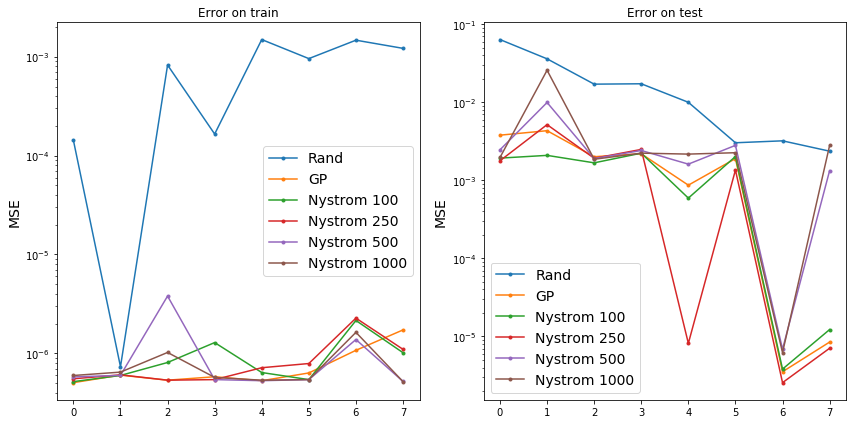

In [31]:
figure = pyplot.figure(figsize=(12, 6))

errors = [errors_rand, errors_gp] + errors_nys
names = ['Rand', 'GP'] + ['Nystrom {}'.format(n_inducing) for n_inducing in n_inducing_list]
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    for err, name in zip(errors, names):
        ax.plot(err['mse_' + mode], '.-', label=name)
        # if 'model_mse_train' in err:
        #     ax.plot(err['model_mse_' + mode], '.-', label=name + ' model error')
        ax.set_ylabel('MSE', fontsize=14)
        ax.set_yscale('log')
        ax.legend(loc='best', fontsize=14)
        ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

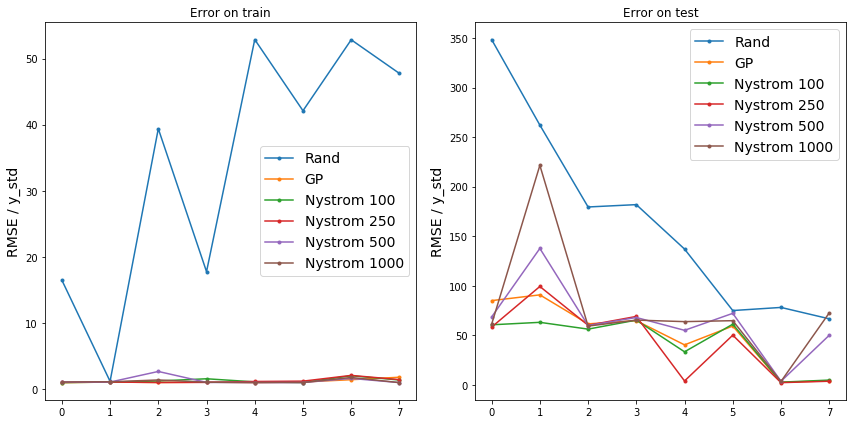

In [33]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    
    for err, name in zip(errors, names):
        ax.plot(err['rel_' + mode], '.-', label=name)
        # if 'model_rel_train' in err:
        #     ax.plot(err['model_rel_' + mode], '.-', label=name + ' model error')
    pyplot.ylabel('RMSE / y_std', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

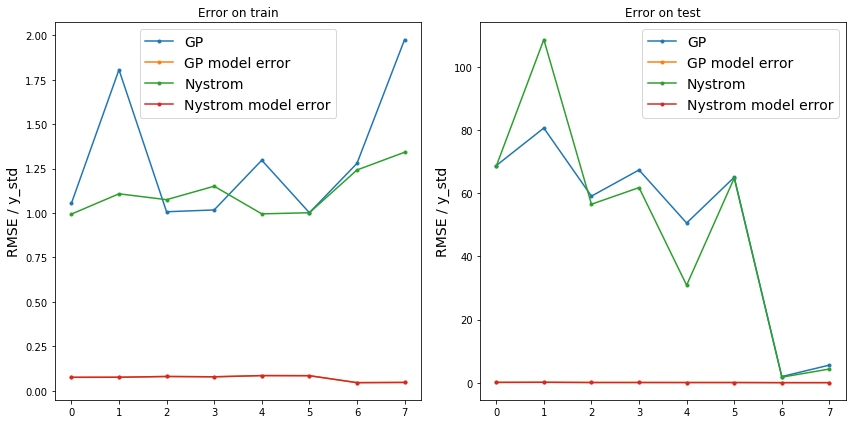

In [18]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    
    for err, name in zip([errors_gp, errors_nys], ['GP', 'Nystrom']):
        ax.plot(err['rel_' + mode], '.-', label=name)
        ax.plot(err['model_rel_' + mode], '.-', label=name + ' model error')
    ax.set_ylabel('RMSE / y_std', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

#### Load errors

In [4]:
import pickle
with open('Cookie100_krr_as_init_errors_rand.pkl', 'rb') as f:
    errors_rand = pickle.load(f)

with open('Cookie100_krr_as_init_errors_krr.pkl', 'rb') as f:
    errors_krr = pickle.load(f)

In [32]:
optimal_lengthscale = model_gp.kern.lengthscale[0]
# model_gp.kern.lengthscale[0] = 1
model_gp.kern.lengthscale[0] = optimal_lengthscale

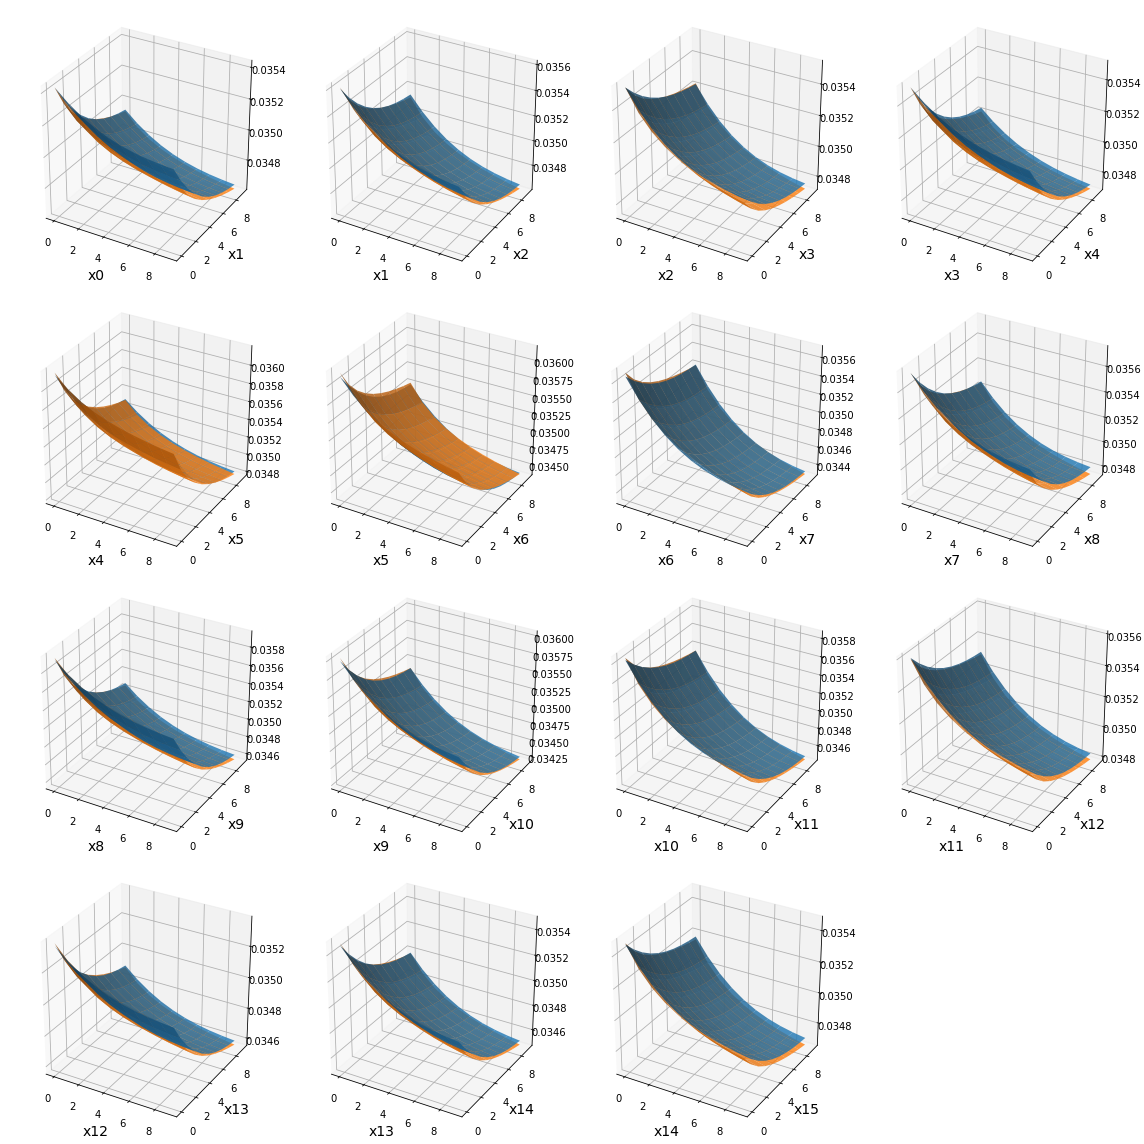

In [36]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
value = np.random.randint(n, size=(1, p_train.shape[1]))

model_gp = results_gp[2]

figure = pyplot.figure(figsize=(16, 16))
m = int(np.sqrt(d))
for i in range(p_train.shape[1]):
    for j in range(i + 1, min(i + 2, p_train.shape[1])):  # p_train.shape[1]):
        idx = [i, j]

        plot_size = n
        dim = 2

        x0 = np.tile(value, (plot_size**dim, 1))
        XY = np.meshgrid(np.arange(n), np.arange(n))
        x_grid = np.hstack([XY[0].reshape(-1, 1), XY[1].reshape(-1, 1)])
        x0[:, idx] = x_grid
        
        y_exact = get_tensor_element(ttcross, x0)
        y_pr = model_gp.predict(x0 / (n - 1))[0]

        ax = figure.add_subplot(m, m, i + 1, projection='3d')
        ax.plot_surface(XY[0], XY[1], y_pr.reshape(plot_size, plot_size), alpha=0.8)
        ax.plot_surface(XY[0], XY[1], y_exact.reshape(plot_size, plot_size), alpha=0.8)
        
        ax.set_xlabel('x{}'.format(i), fontsize=14)
        ax.set_ylabel('x{}'.format(j), fontsize=14)
figure.tight_layout()
pyplot.show()

# Random init vs. GP init for TT-cross (black-box)

In [21]:
random_state = np.random.RandomState(42)

# train_size_list = [300, 1000, 5000, 10000]
train_size_list = [5000]

m_list = [4]

n = 10
r = 2

errors_gp_as_init = {'fun_evals': [], 'mse': []}
errors_bb = {'fun_evals': [], 'mse': []}
for m in m_list:
    for train_size in train_size_list:
        
        d = int(m**2)
        n = int(n)
        train_size = int(train_size)
        size = [n for _ in range(d)]

        y_train, p_train, indices_train = get_data((train_size, d), n, random_state=random_state)

        y_test, p_test, indices_test = get_data((5000, d), n, random_state=random_state)
        
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
            
        # Make tensor completion using GP+TT-cross as init
        kernel = GPy.kern.RBF(d)
        size = np.asarray(size)
        model = GPy.models.GPRegression(p_train / (size - 1), y_train, kernel)
        model.optimize(messages=True)

        x0 = tt.rand(size, d, r)
        x0 = rect_cross.cross(lambda x: model.predict(x / (size - 1))[0], x0, nswp=2, kickrank=1, rf=2)

        fun_evals = [0]
        x_gp_as_init = rect_cross.cross(lambda x: get_tensor_element(ttcross, x, fun_evals), x0, nswp=5, kickrank=1, rf=2)

        # 
        x0 = tt.rand(size, d, r)
        fun_evals_bb = [0]
        x_bb = rect_cross.cross(lambda x: get_tensor_element(ttcross, x, fun_evals_bb), x0, nswp=5, kickrank=1, rf=2)
        
        errors_gp_as_init['mse'].append(calc_mse(y_test, x_gp_as_init, indices_test))
        errors_gp_as_init['fun_evals'].append(fun_evals[0])
        
        errors_bb['mse'].append(calc_mse(y_test, x_bb, indices_test))
        errors_bb['fun_evals'].append(fun_evals_bb[0])
        
        print(errors_gp_as_init['mse'][-1], fun_evals)
        print(errors_bb['mse'][-1], fun_evals_bb)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    13s49  0004  -3.691730e+04   1.885210e+06 
    43s72  0013  -3.985191e+04   1.772648e+02 
 01m13s91  0022  -3.987979e+04   6.176403e-01 
 01m27s36  0026  -3.987982e+04   1.319901e-06 
Runtime:  01m27s36
Optimization status: Converged

swp: 0/1 er_rel = 3.1e+03 er_abs = 1.1e+10 erank = 4.0 fun_eval: 2650
swp: 1/1 er_rel = 2.4e-04 er_abs = 8.5e+02 erank = 6.8 fun_eval: 10750
swp: 0/4 er_rel = 1.8e-03 er_abs = 6.5e+03 erank = 11.4 fun_eval: 22620
swp: 1/4 er_rel = 1.3e-15 er_abs = 4.8e-09 erank = 17.0 fun_eval: 78960
swp: 0/4 er_rel = 1.5e+03 er_abs = 5.2e+09 erank = 4.0 fun_eval: 2640
swp: 1/4 er_rel = 1.2e-15 er_abs = 4.3e-09 erank = 6.7 fun_eval: 10690
[1.06473111e-33] [78960]
[7.95832772e-34] [10690]


In [11]:
import pickle

with open('../notebooks/ttcross_n_cookies=16.pkl', 'rb') as f:
    ttcross = pickle.load(f)

In [15]:
d = 16
n = 10
y_test = np.load('../notebooks/y_test100_{}_{}.npy'.format(d, n))
indices_test = np.load('../notebooks/indices_test100_{}_{}.npy'.format(d, n))

In [18]:
mse = calc_mse(y_test, ttcross, indices_test)
print(mse, mse / y_test.std())

3.577873371079044e-05 0.03381982502560739
